# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [202]:
import pandas as pd

data = pd.read_excel('alldata.xlsx')

print(data.head())

   530  531  533  534  535  537  538  540  541  543  ...  9a  9b  10a  10b  \
0   -1   -2    1   -2    2    1   -2    1    1    2  ...   2   0    1   -2   
1    2    2   -1   -2   -1   -2    1   -2    2   -2  ...  -2   0   -1    2   
2    2    1   -2   -2    1   -2    1   -1    1   -1  ...  -1  -2    0    2   
3    2    1   -2   -1    1    1    1    1    1   -2  ...  -2   2    2    2   
4    1    1   -2    2   -2    1   -2    1    2   -2  ...  -2   0   -1    0   

   11a  11b  12a  12b               storkreds  alder  
0   -2    1    1    1    Københavns Storkreds     78  
1    1   -2    0    0          Fyns Storkreds     64  
2    0   -1    1   -2     Bornholms Storkreds     37  
3    2   -1    2    0  Nordjyllands Storkreds     28  
4   -2    0    2   -2    Københavns Storkreds     58  

[5 rows x 53 columns]


In [203]:
average_age = data.groupby('parti')['alder'].mean().sort_values(ascending=False)
print(average_age)

parti
Danmarksdemokraterne                           51.216216
Kristendemokraterne                            49.023810
Løsgænger                                      48.000000
Nye Borgerlige                                 47.568627
Venstre                                        46.678571
Alternativet                                   46.000000
Dansk Folkeparti                               45.530612
Radikale Venstre                               44.955224
Socialdemokratiet                              44.344828
Moderaterne                                    44.261905
Det Konservative Folkeparti                    42.897959
Socialistisk Folkeparti                        40.928571
Enhedslisten                                   40.513514
Liberal Alliance                               36.885714
Frie Grønne, Danmarks Nye Venstrefløjsparti    34.807692
Name: alder, dtype: float64


And it turns out Danmarksdemokraterne is the 'oldest' party and Frie Grønne is the 'youngest' party, when considering the average age of the members.

This is not surprising when you consider their political opinions and voter base.

To see who has the most extreme opinions, we can look at how many times a candidate has answered 'strongly agree' or 'strongly disagree' to a question.

In [204]:
data_questions = data.drop(['alder', 'storkreds', 'parti'], axis=1)

answered_with_2_or_minus_2 = data_questions.groupby('navn').apply(lambda x: (x == 2) | (x == -2)).sum(axis=1)

print(answered_with_2_or_minus_2.reset_index(level=1, drop=True).sort_values(ascending=False).head(10))

navn
Søren Vanting          49
Sarah Nørris           49
Kim Andkjær Doberck    44
Rashid Ali             43
Mohamed Abdikarim      43
Frank Sørensen         42
Elise Bjerkrheim       42
Lone Vase Langballe    42
John Bjerg             42
Jan Filbært            42
dtype: int64


It turns out that Søren Vanting and Sarah Nørris are tied for the most "extreme" opinions. Vanting is from Det Konserative Folkeparti and Nørris is from Enhedslisten. So it seems there is extreme opinions on both sides of the political spectrum.

In [205]:
# Drop løsgænger as they are not relevant for the statistical analysis and might cause class imbalance later
data = data[data['parti'] != 'Løsgænger']

We are making dictionaries for each subject, that we want to compare the candidates in.

The dictionary consists of a key, that is the id of the question. And a value that is a boolean that dictates if answering "2" to the question is generally considered progressive or conservative.

E.g.: "Den økonomiske ulighed i det danske samfund bør mindskes?"
- "2": "Ulighed skal mindskes" (progressive)
- "-2": "Ulighed skal øges/ikke ændres" (conservative)

In [206]:

economy_questions = {
    "name": "Economy",
    "questions": {
      '4a': True,
      '4b': True,
      '541': True,
      '531': True,
      '537': False,
  }
}

immigration_questions = {
  "name": "Immigration",
  "questions": {
    '6a': True,
    '6b': False,
    '555': False,
    '551': False,
  }
}

social_questions = {
  "name": "Social",
  "questions": {
    '10a': False,
    '10b': True,
    '544': True,
    '538': True,
    '550': True,
    '553': False,
  }
}

welfare_questions = {
  "name": "Welfare",
  "questions": {
    '9a': False,
    '557': True,
    '548': True,
    '543': False,
    '545': True,
  }
}

climate_questions = {
  "name": "Climate",
  "questions": {
    '559': True,
    '546': False,
    '530': True,
    '1a': True,
    '1b': True,
    '7a': False,
    '7b': False,
  }
}

Based on these questions, you can create a dictionary of all the candidates opinions on these subjects. One sum for each subject. This will give you an idea of how progressive or conservative a candidate is.

In [207]:
# Make a list of all objects
question_subjects = [economy_questions, immigration_questions, social_questions, welfare_questions, climate_questions]

CandidateOpinions = {}

# Initialize CandidateOpinions for each person
for index, row in data.iterrows():
    CandidateOpinions[row['navn']] = {
        'parti': row['parti'],
        'subjects': {}
    }
    for subject in question_subjects:
        CandidateOpinions[row['navn']]['subjects'][subject["name"]] = 0  # Initialize each subject score to 0

# Assuming data_questions is a dictionary containing questions and values
for index, row in data.iterrows():
    for subject in question_subjects:
        for question, value in subject["questions"].items():  # Use items() to iterate over keys and values
            CandidateOpinions[row['navn']]['subjects'][subject["name"]] += data.get(question, 0)[index] if value else -data.get(question, 0)[index]


# Now we have a value for each subject for each person
print(CandidateOpinions['Mette Abildgaard'])



{'parti': 'Det Konservative Folkeparti', 'subjects': {'Economy': -3, 'Immigration': -1, 'Social': -8, 'Welfare': -4, 'Climate': -1}}


Based on the candidate opinions, you can average the opinions of the candidates to get an idea of how progressive or conservative a party is.

In [208]:
PartyOpinions = {}

# Initialize PartyOpinions for each party
for party in data['parti'].unique():
    PartyOpinions[party] = {}
    for subject in question_subjects:
        PartyOpinions[party][subject["name"]] = 0  # Initialize each subject score to 0


for candidate in CandidateOpinions:
    for subject in question_subjects:
        PartyOpinions[CandidateOpinions[candidate]['parti']][subject["name"]] += CandidateOpinions[candidate]['subjects'][subject["name"]]

party_sizes = data['parti'].value_counts()

for party in PartyOpinions:
    for subject in question_subjects:
        PartyOpinions[party][subject["name"]] /= party_sizes[party]

print(PartyOpinions)


{'Moderaterne': {'Economy': 0.35714285714285715, 'Immigration': 3.261904761904762, 'Social': -2.761904761904762, 'Welfare': 0.7619047619047619, 'Climate': -2.119047619047619}, 'Socialistisk Folkeparti': {'Economy': 8.485714285714286, 'Immigration': 6.328571428571428, 'Social': 5.371428571428571, 'Welfare': 6.085714285714285, 'Climate': 7.614285714285714}, 'Alternativet': {'Economy': 6.373134328358209, 'Immigration': 6.985074626865671, 'Social': 3.4029850746268657, 'Welfare': 5.029850746268656, 'Climate': 9.0}, 'Enhedslisten': {'Economy': 8.81081081081081, 'Immigration': 7.581081081081081, 'Social': 6.297297297297297, 'Welfare': 5.72972972972973, 'Climate': 9.864864864864865}, 'Danmarksdemokraterne': {'Economy': -2.27027027027027, 'Immigration': -7.297297297297297, 'Social': -5.621621621621622, 'Welfare': -0.8378378378378378, 'Climate': -4.513513513513513}, 'Venstre': {'Economy': -3.7023809523809526, 'Immigration': -1.369047619047619, 'Social': -5.095238095238095, 'Welfare': -1.29761904

Based on the party opionions, you can make a bar chart of the parties opinions on each subject. This will give an overview of how progressive or conservative the parties are on each subject.

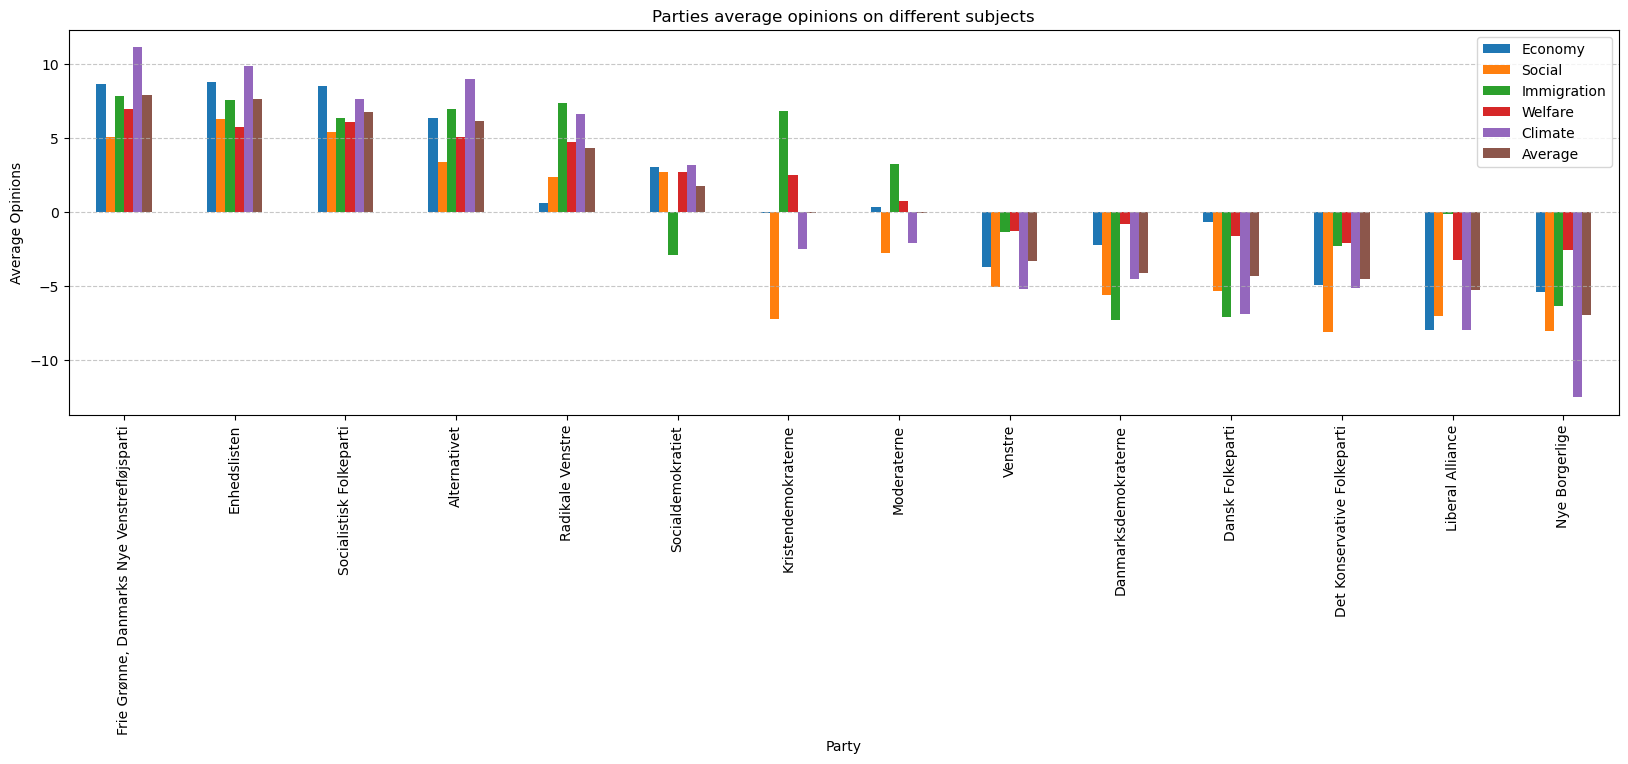

In [209]:
party_data = {
    "Names": list(PartyOpinions.keys()),
    "Economy": [PartyOpinions[party]["Economy"] for party in PartyOpinions],
    "Social": [PartyOpinions[party]["Social"] for party in PartyOpinions],
    "Immigration": [PartyOpinions[party]["Immigration"] for party in PartyOpinions],
    "Welfare": [PartyOpinions[party]["Welfare"] for party in PartyOpinions],
    "Climate": [PartyOpinions[party]["Climate"] for party in PartyOpinions] 
}



df = pd.DataFrame(party_data)

# Calculate the average score for each party
df['Average'] = df.copy().drop('Names', axis=1).mean(axis=1)

# Sort the DataFrame by the 'Average' column in descending order
df_sorted = df.sort_values(by='Average', ascending=False)

df_sorted.set_index('Names', inplace=True)

# Plot the data using pandas plot() method
ax = df_sorted.plot(kind='bar', figsize=(20, 5))

# Add labels and title
ax.set_xlabel('Party')
ax.set_ylabel('Average Opinions')
ax.set_title('Parties average opinions on different subjects')
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines

## So what do we see? 

We have ordered the parties in the order of most extreme left to most extreme right. To see which parties are the most extreme, and which are the most moderate.

It aligns pretty well with what is considered left leaning, moderate and right leaning parties in Denmark.

# Inter party disagreements

1. Beregn den gennemsnittelige uenighed i hvert parti, sammenlign dem med hinanden for at finde det mest "splittede" parti. 
2. Ved at lave noget boxplot så har vi mulighed for at se om ét parti's extremer værdier passer med gennemsnittelige værdier for at andet parti. 

In [210]:
# Now we want to get a list of of all parties, with each individual candidate's opinions on each subject
party_opinions = {}
for candidate in CandidateOpinions.values():
    party = candidate['parti']
    subjects = candidate['subjects']

    # Check if party exists in the dictionary
    if party not in party_opinions:
        party_opinions[party] = {}

    # Add candidate's opinions to the corresponding party and subject
    for subject, score in subjects.items():
        if subject not in party_opinions[party]:
            party_opinions[party][subject] = []

        party_opinions[party][subject].append(score)

print(party_opinions['Frie Grønne, Danmarks Nye Venstrefløjsparti'])

{'Economy': [9, 8, 10, 6, 9, 9, 10, 10, 9, 10, 9, 5, 8, 8, 8, 7, 7, 10, 9, 10, 10, 9, 9, 9, 6, 10], 'Immigration': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8], 'Social': [-6, 2, 8, 5, 5, 3, 4, 3, 9, 6, 8, 7, 5, 5, 6, 6, 7, 7, 2, 3, 8, 4, 9, 4, 3, 8], 'Welfare': [4, 7, 9, 6, 8, 6, 9, 7, 9, 9, 6, 2, 9, 7, 9, 5, 6, 9, 7, 7, 9, 6, 7, 6, 5, 6], 'Climate': [9, 13, 13, 13, 10, 11, 13, 14, 10, 14, 13, 9, 14, 9, 9, 11, 10, 9, 12, 11, 10, 10, 12, 12, 9, 9]}


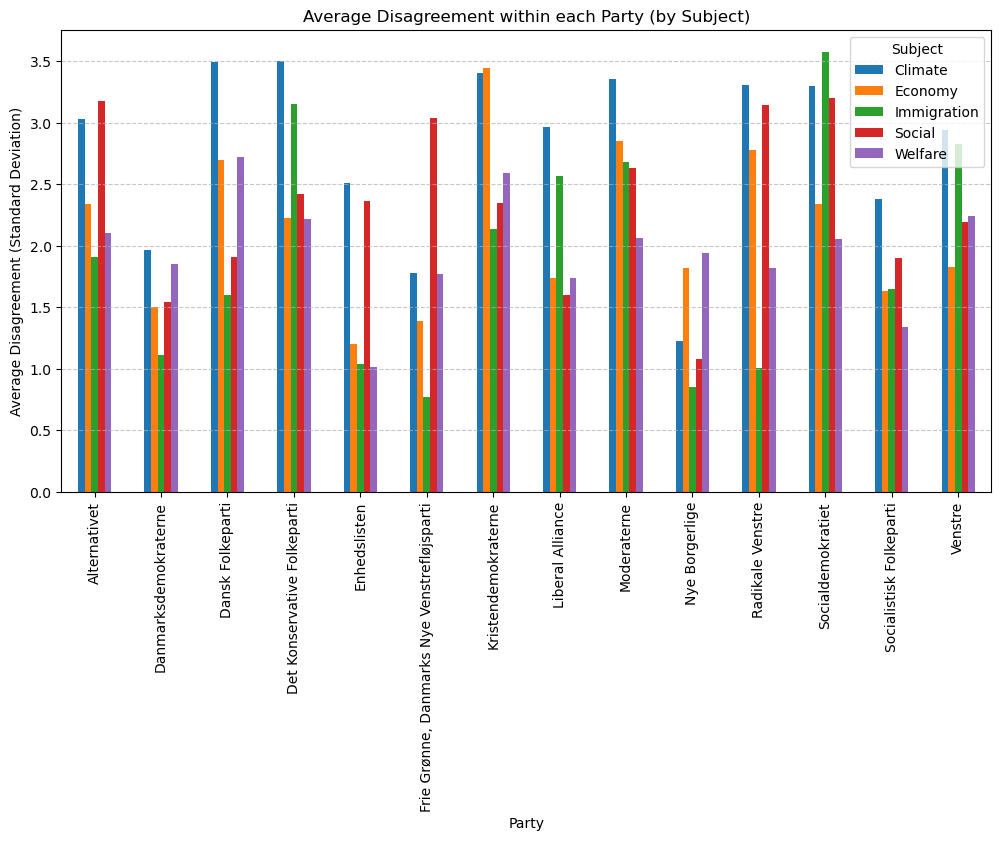

In [211]:
import numpy as np

# Calculate average disagreement for each subject within each party
average_disagreement = {}
for party, opinions_by_subject in party_opinions.items():
  subject_disagreements = []
  for subject, scores in opinions_by_subject.items():
    # Calculate standard deviation (spread) as a measure of disagreement
    disagreement = np.std(scores)
    subject_disagreements.append((subject, disagreement))
  average_disagreement[party] = subject_disagreements

# Create DataFrame and plot
plot_data = []
for party, subject_disagreements in average_disagreement.items():
  for subject, disagreement in subject_disagreements:
    plot_data.append({"Party": party, "Subject": subject, "Disagreement": disagreement})

df = pd.DataFrame(plot_data)
ax = df.pivot_table(index="Party", columns="Subject", values="Disagreement").plot(kind="bar", figsize=(12, 6))

# Add labels and title
ax.set_xlabel("Party")
ax.set_ylabel("Average Disagreement (Standard Deviation)")
ax.set_title("Average Disagreement within each Party (by Subject)")

ax.grid(axis="y", linestyle="--", alpha=0.7)  # Add horizontal grid lines


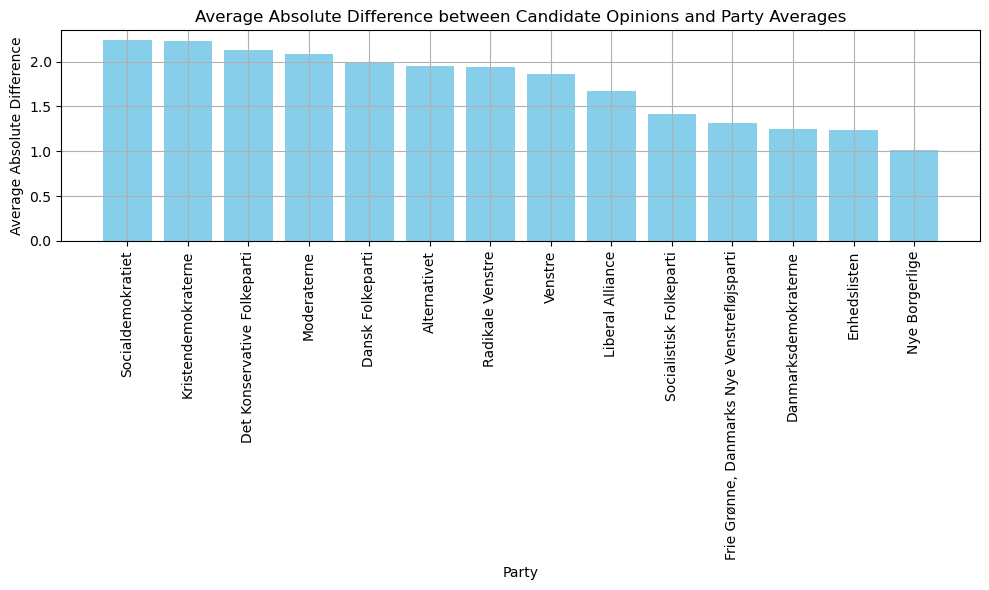

In [212]:
# Dictionary to store absolute differences between candidate opinions and party averages
party_absolute_differences = {}

# Calculate absolute difference for each candidate and each subject
for candidate, opinion in CandidateOpinions.items():
    party = opinion['parti']
    if party not in party_absolute_differences:
        party_absolute_differences[party] = []
    for subject in question_subjects:
        candidate_opinion = opinion['subjects'][subject["name"]]
        party_average = PartyOpinions[party][subject["name"]]
        absolute_difference = abs(candidate_opinion - party_average)
        party_absolute_differences[party].append(absolute_difference)

# Calculate average absolute difference for each party
party_average_absolute_differences = {party: np.mean(differences) for party, differences in party_absolute_differences.items()}

# Sort parties by their average absolute difference in descending order
sorted_parties = sorted(party_average_absolute_differences.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar([party[0] for party in sorted_parties], [party[1] for party in sorted_parties], color='skyblue')
plt.xlabel('Party')
plt.ylabel('Average Absolute Difference')
plt.title('Average Absolute Difference between Candidate Opinions and Party Averages')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

According to the data, it seems like Socialdemokratiet has the most internal disagreements, or at least the largest difference between the candidates opinions and the party average

# Model training

# SVM

In [213]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

In [214]:
# Without age
X = data.copy().drop(['parti', 'alder', 'storkreds', 'navn'], axis=1)
y = data['parti']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   stratify=y, 
                                                   random_state=42)
svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.97
Accuracy on test set: 0.92


In [215]:
# With age, no scaling
X = data.copy().drop(['parti', 'storkreds', 'navn'], axis=1)
y = data['parti']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   stratify=y, 
                                                   random_state=42)
svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.73
Accuracy on test set: 0.73


In [216]:
# Age with scaling
X = data.copy().drop(['parti', 'storkreds', 'navn'], axis=1)
y = data['parti']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   stratify=y, 
                                                   random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.97
Accuracy on test set: 0.92


# Optimizing

Now we will try to optimize the models using GridSearchCV. 

In [217]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [218]:
model = SVC(random_state=42)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Grid search
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Results
print("Best Score: ", grid_search.best_score_, "Best parameters:", grid_search.best_params_, )
mean = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']

for mean, param in zip(mean, params):
    print(mean, param)

Best Score:  0.919773404889684 Best parameters: {'C': 10, 'gamma': 0.01}
0.11420393559928443 {'C': 0.001, 'gamma': 0.001}
0.11420393559928443 {'C': 0.001, 'gamma': 0.01}
0.11420393559928443 {'C': 0.001, 'gamma': 0.1}
0.11420393559928443 {'C': 0.001, 'gamma': 1}
0.11420393559928443 {'C': 0.001, 'gamma': 10}
0.11420393559928443 {'C': 0.001, 'gamma': 100}
0.11420393559928443 {'C': 0.01, 'gamma': 0.001}
0.11420393559928443 {'C': 0.01, 'gamma': 0.01}
0.11420393559928443 {'C': 0.01, 'gamma': 0.1}
0.11420393559928443 {'C': 0.01, 'gamma': 1}
0.11420393559928443 {'C': 0.01, 'gamma': 10}
0.11420393559928443 {'C': 0.01, 'gamma': 100}
0.11420393559928443 {'C': 0.1, 'gamma': 0.001}
0.17440667859272513 {'C': 0.1, 'gamma': 0.01}
0.5848777579010138 {'C': 0.1, 'gamma': 0.1}
0.1296362552176506 {'C': 0.1, 'gamma': 1}
0.11420393559928443 {'C': 0.1, 'gamma': 10}
0.11420393559928443 {'C': 0.1, 'gamma': 100}
0.1697793679189028 {'C': 1, 'gamma': 0.001}
0.8287656529516993 {'C': 1, 'gamma': 0.01}
0.912069171138

In [219]:
# Testing with test data from most optimal hyper parameters

svm_test_result = grid_search.best_estimator_.score(X_test_scaled, y_test)
print("Accuracy on testing set: {}".format(svm_test_result))


Accuracy on testing set: 0.9166666666666666


# SVM Conclusion

We found out that using the parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'} we get the best results.
Including the ages and scaling them. 

# KNN

In [220]:
from sklearn.neighbors import KNeighborsClassifier


In [221]:
model = KNeighborsClassifier()
param_grid = {
    "n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], # We will try different numbers of neighbors
}

# Grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Results
print("Best Score: ", grid_search.best_score_, "Best parameters:", grid_search.best_params_, )
mean = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']
for mean, param in zip(mean, params):
    print(mean, param)

Best Score:  0.885855694692904 Best parameters: {'n_neighbors': 5}
0.8503279666070362 {'n_neighbors': 1}
0.8703995229576625 {'n_neighbors': 3}
0.885855694692904 {'n_neighbors': 5}
0.8657960644007157 {'n_neighbors': 7}
0.8828026237328563 {'n_neighbors': 9}
0.882814549791294 {'n_neighbors': 11}
0.8781753130590341 {'n_neighbors': 13}
0.8812522361359572 {'n_neighbors': 15}
0.8796541443053071 {'n_neighbors': 17}
0.8750506857483602 {'n_neighbors': 19}
0.8704233750745377 {'n_neighbors': 21}
0.8673106738223018 {'n_neighbors': 23}
0.8688849135360762 {'n_neighbors': 25}
0.8596183661299939 {'n_neighbors': 27}
0.862695289206917 {'n_neighbors': 29}


From here we can see that 5 neighbors seems to be the best choice. 

In [222]:
print("Accuracy on training set: {}".format(grid_search.best_estimator_.score(X_train_scaled, y_train)))
print("Accuracy on testing set: {}".format(grid_search.best_estimator_.score(X_test_scaled, y_test)))

Accuracy on training set: 0.9228395061728395
Accuracy on testing set: 0.8703703703703703


# Tree-based models

We do not use the scaled dataset, because decision trees are generally not sensitive to the scale of features.

## Random forest

In [223]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4] 
}

# Grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Results
print("Best Score: ", grid_search.best_score_, "Best parameters:", grid_search.best_params_, )
mean = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']
for mean, param in zip(mean, params):
    print(mean, param)

Best Score:  0.9043530113297555 Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
0.8935837805605248 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.8874180083482409 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.8936076326774002 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
0.8920214669051878 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.8935837805605248 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.8982110912343471 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
0.893536076326774 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
0.8920095408467501 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.895122

We can now determine that the best hyperparameters are: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}.
We might want to limit max_depth in the future to improve the perfomance of the model.

In [224]:
print("Accuracy on training set: {}".format(grid_search.best_estimator_.score(X_train, y_train)))
print("Accuracy on testing set: {}".format(grid_search.best_estimator_.score(X_test, y_test)))

Accuracy on training set: 0.9845679012345679
Accuracy on testing set: 0.9166666666666666


## Descision tree

In [225]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4] 
}

# Grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Results
print("Best Score: ", grid_search.best_score_, "Best parameters:", grid_search.best_params_, )
mean = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']
for mean, param in zip(mean, params):
    print(mean, param)

Best Score:  0.7206320810971973 Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.717602862254025 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.7004770423375074 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.7160166964818127 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.7004889683959451 {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.7082409063804411 {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.7098032200357781 {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.691258199165176 {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
0.691258199165176 {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
0.6958974358974358 {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
0.6821466905187835 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.6836732259988073 {'max_dep

In [226]:
print("Accuracy on training set: {}".format(grid_search.best_estimator_.score(X_train, y_train)))
print("Accuracy on testing set: {}".format(grid_search.best_estimator_.score(X_test, y_test)))

Accuracy on training set: 0.8919753086419753
Accuracy on testing set: 0.7546296296296297


There is a big gap between the training and the test score, which indicates that the model is overfitting. In addition the score is not very high, compared to the other models.

But lets visualize the tree and see what the best predictors are.

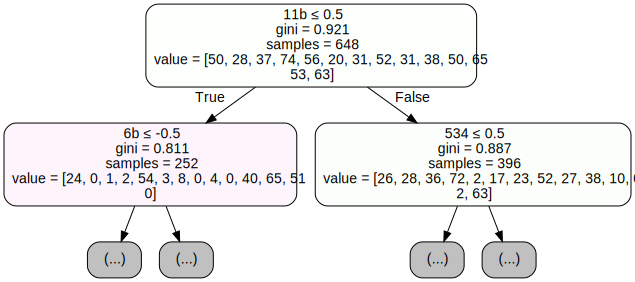

In [227]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(grid_search.best_estimator_, out_file=None,
              feature_names=X.columns, filled=True, rounded=True,
              special_characters=True, max_depth=1)

graph = graphviz.Source(dot_data)
graph

The best predictor was question **11b**, which is the following:
> **11b:** *Det bør undersøges, om Mette Frederiksen kan stilles for en rigsret som konsekvens af hendes håndtering af Mink-sagen.*

Which is a question about the Mink-saga, which was a big scandal in Denmark.

Interestingly this is not about one of the big subjects in politics (economy, immigration, climate etc.), but about a specific event.

The second best predictors was question **6b** and **534**.
> **6b:** *Det vil være en god idé at etablere et dansk asylmodtagecenter i Rwanda.*

> **534:** *På sigt skal Danmark meldes ud af EU*

These questions are very standard political questions in comparison to **11b**, and discusses immigration and foreign policy.

# Gradient Boosted Trees

In [228]:
from sklearn.ensemble import GradientBoostingClassifier
# Gridsearch setup
gbt_model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2,3],
    'learning_rate': [0.01, 0.1, 1],
}

# Grid search
grid_search = GridSearchCV(gbt_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Results
print("Best Score: ", grid_search.best_score_, "Best parameters:", grid_search.best_params_, )
mean = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']
for mean, param in zip(mean, params):
    print(mean, param)

Best Score:  0.8827906976744186 Best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150}
0.7778413834227788 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50}
0.8117710196779964 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}
0.8380083482409063 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 150}
0.7701252236135956 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.8210137149672032 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.8364221824686939 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
0.8766010733452594 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
0.8812403100775195 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
0.8827906976744186 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150}
0.8611568276684556 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.8627429934406677 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.8658199165175908 {

# GBT Results
using the gridsearch we see that the best parameters are: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150}

In [229]:
# Accuracy on training and testing set
print("Accuracy on training set: {}".format(grid_search.best_estimator_.score(X_train, y_train)))
print("Accuracy on testing set: {}".format(grid_search.best_estimator_.score(X_test, y_test)))

Accuracy on training set: 1.0
Accuracy on testing set: 0.8611111111111112


## Using SVM to determine whether any candidates are in the wrong party
We chose to use SVM as it had the best performance of the models.

In [230]:
# Prepare features for candidates
candidate_features = data.copy().drop(['parti', 'storkreds', 'navn'], axis=1)
candidate_features_scaled = scaler.transform(candidate_features)

# Predict parties using the SVM model
predicted_parties = svc.predict(candidate_features_scaled)

# Actual parties of the candidates
actual_parties = data['parti'].values

# Calculate accuracy
accuracy = accuracy_score(actual_parties, predicted_parties)
print("Accuracy:", accuracy)

# Compare predicted parties with actual parties for each candidate
for i, candidate in enumerate(data.index):
    if actual_parties[i] != predicted_parties[i]:
        print("Candidate:", candidate)
        print("Actual Party:", actual_parties[i])
        print("Predicted Party:", predicted_parties[i])
        print("-------------------------------------------")

Accuracy: 0.9594907407407407
Candidate: 3
Actual Party: Alternativet
Predicted Party: Socialdemokratiet
-------------------------------------------
Candidate: 37
Actual Party: Venstre
Predicted Party: Det Konservative Folkeparti
-------------------------------------------
Candidate: 42
Actual Party: Frie Grønne, Danmarks Nye Venstrefløjsparti
Predicted Party: Alternativet
-------------------------------------------
Candidate: 63
Actual Party: Liberal Alliance
Predicted Party: Det Konservative Folkeparti
-------------------------------------------
Candidate: 91
Actual Party: Det Konservative Folkeparti
Predicted Party: Venstre
-------------------------------------------
Candidate: 92
Actual Party: Det Konservative Folkeparti
Predicted Party: Liberal Alliance
-------------------------------------------
Candidate: 129
Actual Party: Enhedslisten
Predicted Party: Socialistisk Folkeparti
-------------------------------------------
Candidate: 139
Actual Party: Venstre
Predicted Party: Det Kon